In [3]:
# This is an implementation of imp step based on Gorte paper 

In [1]:
# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from shapely.geometry import Point, LineString, Polygon
import pyproj 
from algorithms import mm_utils
from Fuzzy.FIS1 import FIS1
# read data 
gdf = pd.read_pickle('envirocar.pkl')

print(gdf.crs)
# get road network 
# Get the bounding box
bbox = gdf.total_bounds

# 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
minx, miny, maxx, maxy = bbox


# Download a map by specifying the bounding box
# and draw the graph
G = ox.graph.graph_from_bbox(maxy, miny, maxx, minx, network_type='drive') #

None


In [2]:
def get_bearing(point1, point2):
    # this code calculate the bearing of any given pair of longitude, latitude  
    geodesic = pyproj.Geod(ellps='WGS84')
    fwd_azimuth,back_azimuth,distance = geodesic.inv(point1[0], point1[1], point2[0], point2[1])
    return fwd_azimuth

def edge_bearing(edge):
    # this function calculate the bearing from the starting and ending node of each road segment
    bearing = get_bearing(edge[0], edge[len(edge) - 1])
    return(bearing)
    
def conv_angle(angle):
    # this function convert angle from -pi,pi to 0,2*pi
    if angle < 0 :
        angle = angle + 360
    return(angle)

def conc(a):
    #function to convert list or integer in osmid into a unique string id 
    if type(a) is int:
        return str(a)
    ans = ",".join(map(str, a))
    return ans


In [14]:
initial_links = pd.DataFrame(columns=['V1', 'V2', 'edge_id', 'direction', 'NP_x', 'NP_y'])

edge_link = []
count = 0 
same_link = 0
stop_iter = False
iter = 0
fis_res = []
HE_iter = [] 
FIS_

# save candidate link name each iteration  
candidate_link_res = []

while stop_iter == False :
#for i in range(13, 17):
    #print(iter)
    # get position 
    lon = gdf['geometry'].x[iter]
    lat = gdf['geometry'].y[iter]
    curr_point = np.array([lon, lat])

    #----------------------------------------
    # create error region as SpatialPolygon 
    #----------------------------------------
    # error size 
    err_size = 38
    # initialzie points 
    # use utm for crs : 
    UTMzone = (180 + 5) // 6 + 1
    #crs_str = f"+proj=utm +zone={UTMzone} +ellps=WGS84 +datum=WGS84"
    crs_str ="epsg:4326"

    # initialize projection to standard WGS 84 
    locs = gpd.GeoDataFrame(geometry = gdf['geometry'], crs = crs_str)

    #change gdf to utm 31 projection epsg 32631
    locs_utm = locs.to_crs({'init': 'epsg:32631'})


    # convert to geodataframe -- assign the CRS using epsg code 
    curr_loc = gpd.GeoDataFrame(geometry = gpd.points_from_xy([lon], [lat]), crs=crs_str)

    # convert ot UTM zone 31 which is equal to epsg32631 according to https://spatialreference.org/ref/epsg/32631/
    curr_loc = curr_loc.to_crs({'init': 'epsg:32631'})

    #print(curr_loc['geometry'])

    x = curr_loc['geometry'].x[0]
    y = curr_loc['geometry'].y[0]

    # create rectangular polygon 
    err_coord = [[x - err_size, y + err_size], 
                 [x + err_size, y + err_size],
                 [x + err_size, y - err_size],
                 [x - err_size, y - err_size]]

    poly_coord = Polygon(err_coord)
    # #print(ply_coord)
    df = {'Attribute' : ['name1'], 'geometry':poly_coord}

    #projected to UTM 31 
    err_poly = gpd.GeoDataFrame(df, geometry = 'geometry', crs = "EPSG:32631")


    #plot error polygon for debugging
    # err_poly.plot()

    # extract road info 
    nodes, edges = ox.graph_to_gdfs(G)

    # project edges into UTM 31 projection 
    edges_utm = edges.to_crs({'init': 'epsg:32631'})

    # append latitude and longitude to utm edges 
    edges_utm['lat_lon'] = edges['geometry']



    #print(edges_utm)
    #print(err_poly.crs)

    # Check for intersection and containment using geopandas
    intersects = gpd.sjoin(err_poly, edges_utm, op='intersects')
    contains = gpd.sjoin(err_poly, edges_utm, op='contains')

    # skip iteration if no edges are detected 
    if (len(intersects) + len(contains)) >0:
        print(iter)
    
        # extract index from edges that intersect with error polygon 
        int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
        # extract index from edges that contained in the error polygon 
        cont_index = contains[['index_right0', 'index_right1', 'index_right2']]

        # merge index
        index = pd.concat([int_index, cont_index])
        # drop duplicate
        index = index.drop_duplicates()

        # initialize candidate edges 
        appended_edge = []

        # extract candidate eges  
        for i in range(len(index)):
            edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
            appended_edge.append(edge_list)

        candidate_link = edges_utm.loc[appended_edge]
        
        #save candidate link name 
        candidate_link_res.append(candidate_link['osmid'])
        
        # calculate perpendicular distance 
        # initialize list that hold perpendicular distance between points and edges
        p_dist = []

        # calculate perpendicular distance between current point and 
        for i in range(len(candidate_link)):
            p_dist.append(candidate_link['geometry'].iloc[i].distance(curr_loc).iloc[0, 0])

        # attach perpendicular distance to candidate link 
        candidate_link["perp_dist"] = p_dist



        # print(candidate_link)

        # calculate heading error
        # convert lat lon into tupple coordinate 
        candidate_link['lat_lon_pair'] = candidate_link.lat_lon.apply(lambda geom: list(geom.coords))

        # calculate bearing frome start and end node for each candidate link (see notes below)
        bearing_raw = candidate_link['lat_lon_pair'].apply(edge_bearing)

        # convert bearing from -pi, pi to 0, 2pi range
        candidate_link['edge_heading'] = bearing_raw.apply(conv_angle)

        # heading error = abs(gps heading - edge bearing)
        candidate_link['heading_error'] = abs(candidate_link['edge_heading'] - gdf['GPS Bearing'].iloc[iter])

        # initialize input for FIS
        PD = candidate_link['perp_dist']
        HE = candidate_link['heading_error']
        speed = np.repeat(gdf['GPS Speed'][iter], len(candidate_link))
        hdop = np.repeat(gdf['GPS HDOP'][iter], len(candidate_link))
        
        # save HE value every iter 
        HE_iter.append(HE)
        # rearrange new data to the input of fis1  
        new_data = np.array([speed, HE, PD, hdop]).T

        # calculating FIS
        pred =[]
        for i in range(len(new_data)):
            pred.append(FIS1(new_data[i,:], plot = False))

        # print(pred)
        # save fis result 
        fis_res.append(pred)

        # pick candidate link based on 
        index = pred.index(max(pred))

        edge_link.append(candidate_link['osmid'].iloc[index])
    
        # check if the current position and previous position is in the same edge
        if count > 0:
            if edge_link[count] == edge_link[count - 1]:
                same_link = same_link + 1
            else:
                same_link = 0
    
        # check to stop the for loop if three points belong to the same edge
        if same_link == 1:
            stop_iter = True
        else:
            count = count + 1
    
    #update iteration 
    iter = iter + 1 

    

# Combine the indices from both operations
#id = list(set(intersects['osmid'] + contains['osmid']))

#print(intersects)
#print(contains)
#print(indices)
#print(candidate_link)

# Create the candidate_links data frame
#candidate_links = roads.iloc[indices][['edge_id']].reset_index(drop=True)

# Print the candidate_links data frame
#print(candidate_links)


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making th

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\cr

11
12


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>

In [11]:
# seemes like the bearing calculated from starting point to any other node in between polyline is almost the same
# to reduce time we will calculate the bearing from the start and end node for each edges
for i in range(len(candidate_link)):
    print(['candidate', i] )
    edge_i = candidate_link['lat_lon_pair'].iloc[i]
    for j in range(len(edge_i) - 1):
        print(get_bearing(edge_i[0], edge_i[j + 1]))


['candidate', 0]
94.50771410309437
94.47203130270282
94.3125270820487
94.30565591971019
94.50263182457175
94.28964716275141
93.99778580605815
['candidate', 1]
-87.47633559258185
-87.48783231676614
-86.56340510965829
-86.46190901454015
-86.22617891559244
-86.05043728975816
-86.00158503994939
['candidate', 2]
-85.58191988683704
-85.58184090553345
-85.42291668245923
['candidate', 3]
94.70555675229399
94.64475845710278
94.57665978623733
['candidate', 4]
-177.7738928383955
-178.26239227713606
-178.2954561732137
-178.31902595531164
-178.33589459208073
-178.3124783858985
-178.31590363557882
['candidate', 5]
1.6378169714324728
1.8084525798632105
1.6980875652948715
1.6181215864629488
1.5587516232876806
1.436878292955109
1.6840693521754933


,,,osmid,lanes,ref,name,highway,maxspeed,oneway,reversed,length,geometry,width,access,lat_lon,perp_dist,lat_lon_pair,edge_heading,heading_error
u,v,key,,,,,,,,,,,,,,,,,
53200191,135535395,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,True,54.889,"LINESTRING (819585.705 5766245.100, 819590.522...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65188 51.95486...",15.815905,"[(7.651807, 51.9548654), (7.6518768, 51.954862...",93.997786,203.502214
135535395,53200191,0,"[673214248, 234046511]",3,L 793,Wolbecker Straße,secondary,50,False,False,54.889,"LINESTRING (819640.807 5766244.782, 819631.704...",NaN,NaN,"LINESTRING (7.65261 51.95483, 7.65247 51.95483...",15.815905,"[(7.6526059, 51.9548309), (7.6524737, 51.95483...",273.998415,23.501585
53200191,6152925224,0,470244584,3,L 793,Wolbecker Straße,secondary,50,False,False,36.973,"LINESTRING (819585.705 5766245.100, 819574.575...",NaN,NaN,"LINESTRING (7.65181 51.95487, 7.65165 51.95487...",28.933227,"[(7.651807, 51.9548654), (7.6516457, 51.954873...",274.577083,22.922917
6152925224,53200191,0,470244584,3,L 793,Wolbecker Straße,secondary,50,False,True,36.973,"LINESTRING (819548.588 5766245.690, 819569.082...",NaN,NaN,"LINESTRING (7.65127 51.95489, 7.65157 51.95488...",28.933227,"[(7.6512692, 51.954892), (7.6515661, 51.954876...",94.576660,202.923340
135535401,135535395,0,14180413,2,NaN,Andreas-Hofer-Straße,residential,NaN,False,True,80.186,"LINESTRING (819638.028 5766325.038, 819638.661...",NaN,NaN,"LINESTRING (7.65264 51.95555, 7.65263 51.95533...",34.857916,"[(7.6526402, 51.9555517), (7.652626, 51.955326...",181.684096,115.815904
135535395,135535401,0,14180413,2,NaN,Andreas-Hofer-Straße,residential,NaN,False,False,80.186,"LINESTRING (819640.807 5766244.782, 819640.611...",NaN,NaN,"LINESTRING (7.65261 51.95483, 7.65261 51.95488...",34.857916,"[(7.6526059, 51.9548309), (7.6526082, 51.95488...",1.684069,295.815931


In [15]:
print(count)
print(edge_link)
print(candidate_link_res)
print(HE_iter)
fis_res

1
[[673214248, 234046511], [673214248, 234046511]]
[u          v          key
53200191   135535395  0      [673214248, 234046511]
135535395  53200191   0      [673214248, 234046511]
135535401  135535395  0                    14180413
135535395  135535401  0                    14180413
Name: osmid, dtype: object, u           v           key
53200191    135535395   0      [673214248, 234046511]
135535395   53200191    0      [673214248, 234046511]
53200191    6152925224  0                   470244584
6152925224  53200191    0                   470244584
135535401   135535395   0                    14180413
135535395   135535401   0                    14180413
Name: osmid, dtype: object]
[u          v          key
53200191   135535395  0      210.602220
135535395  53200191   0       30.601591
135535401  135535395  0      122.915910
135535395  135535401  0      302.915937
Name: heading_error, dtype: float64, u           v           key
53200191    135535395   0      203.502214
135535395   

[[13.707015033018788,
  48.04009434833877,
  13.707015034846982,
  13.707015033018788],
 [29.3895817601854,
  52.40817317694824,
  51.243292377113676,
  16.755415213402497,
  11.212249108797751,
  11.212249105352978]]

In [18]:
[gdf['GPS Bearing'].max(),gdf['GPS Bearing'].min()]


[336.3999938964844, 11.899999618530273]

<class 'geopandas.geodataframe.GeoDataFrame'>
(array([ 67, 134], dtype=int64),)


<Axes: >

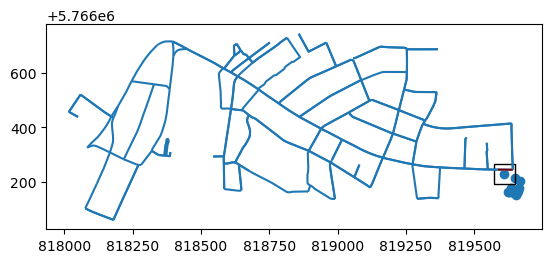

In [7]:
# convert osmid into unique string id 
edges_utm['str_id'] = edges_utm['osmid'].apply(conc)
# This is how we  visualize edges and error bound 
#print(edges)
print(type(edges))

loc = np.where(edges_utm["str_id"] == conc(edge_link[count]))
print(loc)
answer_loc = edges_utm.iloc[loc]

# plotting edges and starting point together 
f, ax = plt.subplots()

# location for all point
#locs_utm.plot(ax=ax)
locs_utm.iloc[0:iter, :].plot(ax = ax)

#current location versus edges
#curr_loc.plot(ax=ax)

#err coord 
err_poly.plot(ax=ax, facecolor="none")

# edges
edges_utm.plot(ax=ax)
answer_loc.plot(ax=ax, cmap = "Reds")

#print(intersects['index_right'])

In [141]:
# extracting index of the intersect edges 
index = intersects[['index_right0', 'index_right1', 'index_right2']]

# extracting data from edges 
edges.loc[(53200191, 135535395, 0)]

for i in range(len(index)):
    print(edges.loc[(intersects['index_right0'].iloc[i], intersects['index_right1'].iloc[i], 0 )])
    

osmid                                  [673214248, 234046511]
lanes                                                       3
ref                                                     L 793
name                                         Wolbecker Straße
highway                                             secondary
maxspeed                                                   50
oneway                                                  False
reversed                                                 True
length                                                 54.889
geometry    LINESTRING (7.651807 51.9548654, 7.6518768 51....
width                                                     NaN
access                                                    NaN
Name: (53200191, 135535395, 0), dtype: object
osmid                                  [673214248, 234046511]
lanes                                                       3
ref                                                     L 793
name                    

In [318]:
df = locs_utm.iloc[10:iter, :] 
df['edge_link'] = edge_link
print(len(locs_utm.iloc[0:iter, :]))
(len(edge_link))
df

20


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,geometry,edge_link
10,POINT (819666.405 5766203.248),14180413
11,POINT (819649.308 5766214.665),"[673214248, 234046511]"
12,POINT (819609.734 5766228.984),"[673214248, 234046511]"
13,POINT (819588.902 5766241.332),470244584
14,POINT (819570.097 5766255.646),"[673214248, 234046511]"
15,POINT (819538.122 5766257.090),148065615
16,POINT (819515.911 5766254.049),"[673214250, 467653690]"
17,POINT (819460.477 5766262.022),148065615
18,POINT (819394.266 5766264.055),148065615
19,POINT (819337.931 5766261.464),148065615


In [355]:
edges_utm

osmid   lanes  ref  \
u           v          key                                                   
21518865    43601038   0    [692976089, 692976090, 801727033]       3  K 8   
21518866    21518865   0      [714428680, 4064467, 820160405]  [3, 2]  NaN   
21518867    21518866   0      [666953657, 4064467, 714428681]       2  NaN   
            60358392   0    [1021975576, 666953658, 30374499]       3  NaN   
21518872    52774658   0                [30374498, 666953655]  [3, 2]  NaN   
...                                                       ...     ...  ...   
6715626972  6715626969 0                            714435226       1  NaN   
9776435595  1932959986 0                             17438340     NaN  NaN   
            6715626972 0                             17438340     NaN  NaN   
            6715626969 0                           1064505851     NaN  NaN   
10548918654 6152925224 0                             28961154     NaN  NaN   

                                                            name  \
u           v          key                                         
21518865    43601038   0                             Hafenstraße   
21518866    21518865   0                             Engelstraße   
21518867    21518866   0                             Engelstraße   
            60358392   0                          Herwarthstraße   
21518872    52774658   0    [Von-Steuben-Straße, Berliner Platz]   
...                                                          ...   
6715626972  6715626969 0                                     NaN   
9776435595  1932959986 0                          Berliner Platz   
            6715626972 0                          Berliner Platz   
            6715626969 0                                     NaN   
10548918654 6152925224 0                             Brunostraße   

                                 highway maxspeed  oneway  reversed   length  \
u           v          key                                                     
21518865    43601038   0       secondary       50   False     False   29.023   
21518866    21518865   0     residential       30    True     False   99.176   
21518867    21518866   0     residential       30    True     False  124.335   
            60358392   0       secondary       30    True     False   56.497   
21518872    52774658   0       secondary       30    True     False   64.592   
...                                  ...      ...     ...       ...      ...   
6715626972  6715626969 0    unclassified      NaN    True     False   59.092   
9776435595  1932959986 0    unclassified      NaN   False     False   27.814   
            6715626972 0    unclassified      NaN   False      True    4.837   
            6715626969 0    unclassified      NaN    True     False   57.953   
10548918654 6152925224 0     residential       30   False     False   97.885   

                                                                     geometry  \
u           v          key                                                      
21518865    43601038   0    LINESTRING (818076.354 5766103.217, 818080.537...   
21518866    21518865   0    LINESTRING (818118.595 5766193.172, 818108.090...   
21518867    21518866   0    LINESTRING (818166.493 5766308.115, 818164.278...   
            60358392   0    LINESTRING (818166.493 5766308.115, 818171.377...   
21518872    52774658   0    LINESTRING (818280.573 5766262.212, 818286.118...   
...                                                                       ...   
6715626972  6715626969 0    LINESTRING (818368.292 5766296.311, 818372.745...   
9776435595  1932959986 0    LINESTRING (818373.118 5766295.771, 818376.985...   
            6715626972 0    LINESTRING (818373.118 5766295.771, 818369.688...   
            6715626969 0    LINESTRING (818373.118 5766295.771, 818377.187...   
10548918654 6152925224 0    LINESTRING (819545.555 5766343.170, 819547.189...   

                           width access  \
u           v     

In [137]:
# print(edges)
# edges.columns.values
#print(edges['osmid'])
for i, v in edges['osmid'].items():
    print(i)
# print(edges['osmid'].values)


# attr = dir(edges['osmid'])
# for x in attr:
#     print(x)
# print(edges['osmid'].loc["u"])


(21518865, 43601038, 0)
(21518866, 21518865, 0)
(21518867, 21518866, 0)
(21518867, 60358392, 0)
(21518872, 52774658, 0)
(21518875, 21518954, 0)
(21518875, 1631144426, 0)
(21518876, 21518867, 0)
(21518954, 60358392, 0)
(21518954, 42908014, 0)
(37513773, 42908014, 0)
(37514058, 41665100, 0)
(37514058, 42907801, 0)
(41665100, 2577185238, 0)
(41665100, 37514058, 0)
(42907691, 1504411732, 0)
(42907691, 314436395, 0)
(42907801, 2505759276, 0)
(42907801, 37514058, 0)
(42907801, 21518876, 0)
(42908014, 2505759277, 0)
(43599624, 52693568, 0)
(43599624, 6152925223, 0)
(43599624, 52139636, 0)
(43599624, 110368894, 0)
(43600642, 43602743, 0)
(43600642, 91718741, 0)
(43600642, 83679375, 0)
(43601038, 443003860, 0)
(43601038, 21518865, 0)
(43602117, 135535323, 0)
(43602117, 43602657, 0)
(43602657, 43602117, 0)
(43602743, 87259614, 0)
(43602743, 83679366, 0)
(43602743, 43600642, 0)
(51516875, 296965826, 0)
(51516875, 52726584, 0)
(51516875, 296965817, 0)
(51516875, 81331484, 0)
(52139612, 135535424, 

In [142]:
# Finding unique index from edges that interesct and edges that contained in the err polygon 
print(intersects)
print(contains)

  Attribute                                           geometry  index_right0  \
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...      53200191   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...     135535395   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...      53200191   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...    6152925224   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...    6152925224   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...      53200192   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...     135535401   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...     135535395   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...   10548918654   
0     name1  POLYGON ((819530.902 5766299.332, 819646.902 5...    6152925224   

   index_right1  index_right2                   osmid lanes    ref  \
0     135535395             0  [673214248, 234046

In [183]:
# extract index from edges that intersect with error polygon 
int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
# extract index from edges that contained in the error polygon 
cont_index = contains[['index_right0', 'index_right1', 'index_right2']]
#print(int_index)
#print(cont_index)

# merge index
index = pd.concat([int_index, cont_index])
# drop duplicate
index = index.drop_duplicates()
#print(index)

# initialize candidate edges 
appended_edge = []

# extract candidate eges  
for i in range(len(index)):
    edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
    appended_edge.append(edge_list)

print(appended_edge)

edges.loc[appended_edge]


[(53200191, 135535395, 0), (135535395, 53200191, 0), (53200191, 6152925224, 0), (6152925224, 53200191, 0), (6152925224, 53200192, 0), (53200192, 6152925224, 0), (135535401, 135535395, 0), (135535395, 135535401, 0), (10548918654, 6152925224, 0), (6152925224, 10548918654, 0)]


osmid lanes    ref  \
u           v           key                                        
53200191    135535395   0    [673214248, 234046511]     3  L 793   
135535395   53200191    0    [673214248, 234046511]     3  L 793   
53200191    6152925224  0                 470244584     3  L 793   
6152925224  53200191    0                 470244584     3  L 793   
            53200192    0    [673214250, 467653690]     2  L 793   
53200192    6152925224  0    [467653690, 673214250]     2  L 793   
135535401   135535395   0                  14180413     2    NaN   
135535395   135535401   0                  14180413     2    NaN   
10548918654 6152925224  0                  28961154   NaN    NaN   
6152925224  10548918654 0                  28961154   NaN    NaN   

                                             name      highway maxspeed  \
u           v           key                                               
53200191    135535395   0        Wolbecker Straße    secondary       50   
135535395   53200191    0        Wolbecker Straße    secondary       50   
53200191    6152925224  0        Wolbecker Straße    secondary       50   
6152925224  53200191    0        Wolbecker Straße    secondary       50   
            53200192    0        Wolbecker Straße    secondary       50   
53200192    6152925224  0        Wolbecker Straße    secondary       50   
135535401   135535395   0    Andreas-Hofer-Straße  residential      NaN   
135535395   135535401   0    Andreas-Hofer-Straße  residential      NaN   
10548918654 6152925224  0             Brunostraße  residential       30   
6152925224  10548918654 0             Brunostraße  residential       30   

                             oneway  reversed  length  \
u           v           key                             
53200191    135535395   0     False      True  54.889   
135535395   53200191    0     False     False  54.889   
53200191    6152925224  0     False     False  36.973   
6152925224  53200191    0     False      True  36.973   
            53200192    0     False     False  22.331   
53200192    6152925224  0     False      True  22.331   
135535401   135535395   0     False      True  80.186   
135535395   135535401   0     False     False  80.186   
10548918654 6152925224  0     False     False  97.885   
6152925224  10548918654 0     False      True  97.885   

                                                                      geometry  \
u           v           key                                                      
53200191    135535395   0    LINESTRING (7.65181 51.95487, 7.65188 51.95486...   
135535395   53200191    0    LINESTRING (7.65261 51.95483, 7.65247 51.95483...   
53200191    6152925224  0    LINESTRING (7.65181 51.95487, 7.65165 51.95487...   
6152925224  53200191    0    LINESTRING (7.65127 51.95489, 7.65157 51.95488...   
            53200192    0    LINESTRING (7.65127 51.95489, 7.65121 51.95489...   
53200192    6152925224  0    LINESTRING (7.65094 51.95491, 7.65121 51.95489...   
135535401   135535395   0    LINESTRING (7.65264 51.95555, 7.65263 51.95533...   
135535395   135535401   0    LINESTRING (7.65261 51.95483, 7.65261 51.95488...   
10548918654 6152925224  0    LINESTRING (7.65132 51.95577, 7.65131 51.95552...   
6152925224  10548918654 0    LINESTRING (7.65127 51.95489, 7.65128 51.95496...   

                            width access  
u           v           key               
53200191    135535395   0     NaN    NaN  
135535395   53200191    0     NaN    NaN  
53200191    6152925224  0     NaN    NaN  
6152925224  53200191    0     NaN    NaN  
            53200192    0     NaN    NaN  
53200192    6152925224  0     NaN    NaN  
135535401   135535395   0     NaN    NaN  
135535395   135535401   0     NaN    NaN  
10548918654 6152925224  0       3    NaN  
6152925224  10548918654 0       3    NaN